<a href="https://colab.research.google.com/github/jdmartinezrs/chatbotDevelopmentPython/blob/main/agendamientodecitas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

pip install gradio

In [ ]:
!pip install git+https://github.com/gunthercox/ChatterBot.git@master
!pip install chatterbot_corpus

  Cloning https://github.com/gunthercox/ChatterBot.git (to revision master) to /tmp/pip-req-build-qa2rhr9v
  Running command git clone --filter=blob:none --quiet https://github.com/gunthercox/ChatterBot.git /tmp/pip-req-build-qa2rhr9v
  Resolved https://github.com/gunthercox/ChatterBot.git to commit 1b26cd4a24848b8f1caf06b9046dfc2dee3caf98
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
pip install gradio

In [ ]:
import gradio as gr
from chatterbot import ChatBot
from chatterbot.trainers import ListTrainer

vehiculos = {
    "irrigador": {"base": 6000, "coeficiente": 0.13, "umbrales": (0, 10000, 16000), "tarifa": 10},
    "volqueta sencilla": {"base": 7000, "coeficiente": 0.16, "umbrales": (0, 8000, 14000), "tarifa": 12},
    "dobletroque": {"base": 6000, "coeficiente": 0.20, "umbrales": (0, 7000, 12000), "tarifa": 13},
    "grua": {"base": 5500, "coeficiente": 0.23, "umbrales": (0, 6000, 10000), "tarifa": 14},
    "carro tanque": {"base": 6500, "coeficiente": 0.25, "umbrales": (0, 9000, 15000), "tarifa": 15},
}

TASA_CAMBIO_DOLAR = 4000

bot = ChatBot("MantenimientoBot")
trainer = ListTrainer(bot)
trainer.train([
    "Hola", "Hola, ¿qué vehículo deseas revisar?",
    "Buenos días", "Hola, ¿qué vehículo deseas revisar?",
    "Buenas tardes", "Hola, ¿qué vehículo deseas revisar?",
    "me gustaria revisar mi vehiculo", "¿qué vehículo tienes?",
    "me gustaria revisar otro vehiculo", "¿qué deseas revisar?",
    "otro", "¿qué vehículo deseas revisar?",
    "¿Qué sabes hacer?", "Puedo decirte cuándo darle mantenimiento a tu vehículo.",
    "¿Para qué sirves?", "Puedo decirte cuándo darle mantenimiento a tu vehículo.",
    "okey", "Hola, ¿qué vehículo deseas revisar?",
    "Chao", "¡Hasta luego! 🚚",
    "Adiós", "¡Hasta luego! 🚚",
    "¿Cuánto cuesta el mantenimiento?", "Puedo decirte el costo estimado si ya ingresaste los datos.",
    "¿Cuál es el valor en dólares?", "Puedo convertirlo si ya calculaste el mantenimiento.",
    "¿Cuánto vale?", "Puedo mostrarte el costo en pesos y dólares.",
    "agendar cita", "Para agendar una cita, dime la placa del vehículo.",
])

# Variables globales
ultimo_precio = None
ultimo_precio_usd = None
tipo_vehiculo_actual = None
datos_vehiculo = None
esperando_km_actual = False
esperando_km_base = False
km_actual_temp = None

# Variables para agendar citas en modo conversacional
citas_agendadas = {}
esperando_placa = False
esperando_datos_cita = False
datos_cita_temp = {}

def clasificar_mantenimiento_por_km(tipo, km_desde_ultimo, datos):
    _, umbral_cercano_km, umbral_urgente_km = datos["umbrales"]
    if km_desde_ultimo >= umbral_urgente_km:
        excedido = km_desde_ultimo - umbral_urgente_km
        return f"❌ {tipo.upper()} necesita mantenimiento urgente. Has pasado {excedido} km del límite."
    elif km_desde_ultimo >= umbral_cercano_km:
        return f"⚠️ {tipo.upper()} pronto requiere mantenimiento."
    else:
        return f"✅ {tipo.upper()} operando normalmente."

def calcular_precio_mantenimiento(desgaste, tarifa):
    return desgaste * tarifa

def responder(usuario_input):
    global ultimo_precio, ultimo_precio_usd, tipo_vehiculo_actual, datos_vehiculo
    global esperando_km_actual, esperando_km_base, km_actual_temp
    global esperando_placa, esperando_datos_cita, datos_cita_temp

    entrada = usuario_input.strip().lower()
    tipos = list(vehiculos.keys())

    # Manejo comandos especiales para citas
    if entrada == "mostrar_solicitudes":
        if not citas_agendadas:
            return "No hay citas agendadas todavía."
        texto = "Estas son las citas agendadas:\n"
        for placa, datos in citas_agendadas.items():
            texto += f"\nPlaca: {placa}\nCiudad: {datos['ciudad']}\nConductor: {datos['nombre']}\nCédula: {datos['cedula']}\nTeléfono: {datos['telefono']}\nCorreo: {datos['correo']}\nTipo de vehículo: {datos['tipo_vehiculo'].title()}\nKm desde último mantenimiento: {datos['km_recorridos']} km\nDesgaste estimado: {datos['desgaste']:.2f}\nCosto COP: {datos['precio_cop']:,.2f}\nCosto USD: {datos['precio_usd']:.2f}\n"
        return texto

    if entrada == "cancelar_solicitud":
        return "Por favor, dime la placa de la cita que deseas cancelar."

    if entrada.startswith("cancelar_solicitud "):
        placa = entrada.replace("cancelar_solicitud ", "").upper()
        if placa in citas_agendadas:
            del citas_agendadas[placa]
            return "Solicitud cancelada exitosamente."
        else:
            return "No se encontró una cita con esa placa."

    if entrada == "editar_solicitud":
        return "Por favor, dime la placa de la cita que deseas editar."

    if entrada.startswith("editar_solicitud "):
        placa = entrada.replace("editar_solicitud ", "").upper()
        if placa in citas_agendadas:
            datos_cita_temp.update({"placa": placa})
            esperando_datos_cita = True
            return "Dime el nuevo nombre del conductor (o escribe 'no' para mantener actual):"
        else:
            return "No se encontró una cita con esa placa."

    # Flujo para agendar cita
    if entrada == "agendar cita":
        esperando_placa = True
        datos_cita_temp.clear()
        return "Por favor, dime la placa del vehículo."

    if esperando_placa:
        placa = entrada.upper()
        if placa in citas_agendadas:
            return "Ya existe una cita para esa placa. Usa 'editar_solicitud {placa}' para modificarla o 'cancelar_solicitud {placa}' para eliminarla."
        datos_cita_temp["placa"] = placa
        esperando_placa = False
        esperando_datos_cita = True
        return "Dime la ciudad:"

    if esperando_datos_cita:
        # Vamos a pedir datos en orden, uno por uno:
        # ciudad, nombre, cedula, telefono, correo, tipo_vehiculo, km_recorridos, desgaste, precio_cop, precio_usd
        campos = ["ciudad", "nombre", "cedula", "telefono", "correo", "tipo_vehiculo", "km_recorridos"]
        for campo in campos:
            if campo not in datos_cita_temp:
                if campo == "km_recorridos":
                    try:
                        km = int(entrada)
                        datos_cita_temp[campo] = km
                    except:
                        return "Por favor ingresa un número válido para los kilómetros recorridos."
                else:
                    if entrada.lower() == "no" and campo in citas_agendadas.get(datos_cita_temp.get("placa", ""), {}):
                        # Mantener valor actual
                        datos_cita_temp[campo] = citas_agendadas[datos_cita_temp["placa"]][campo]
                    else:
                        datos_cita_temp[campo] = entrada.title() if campo in ["ciudad", "nombre", "tipo_vehiculo"] else entrada
                siguiente_campo_index = campos.index(campo) + 1
                if siguiente_campo_index < len(campos):
                    siguiente_campo = campos[siguiente_campo_index]
                    return f"Dime {siguiente_campo.replace('_', ' ')}:"
                else:
                    # Todos los datos recogidos, calcular desgaste y precios
                    tipo = datos_cita_temp["tipo_vehiculo"].lower()
                    if tipo not in vehiculos:
                        return f"Tipo de vehículo '{tipo}' no reconocido. Intenta de nuevo."
                    datos = vehiculos[tipo]
                    km_desde_ultimo = datos_cita_temp["km_recorridos"]
                    coef = datos["coeficiente"]
                    tarifa = datos["tarifa"]
                    desgaste = km_desde_ultimo * coef
                    precio_cop = calcular_precio_mantenimiento(desgaste, tarifa)
                    precio_usd = round(precio_cop / TASA_CAMBIO_DOLAR, 2)
                    datos_cita_temp.update({
                        "desgaste": desgaste,
                        "precio_cop": precio_cop,
                        "precio_usd": precio_usd
                    })
                    placa = datos_cita_temp.pop("placa")
                    citas_agendadas[placa] = datos_cita_temp.copy()
                    esperando_datos_cita = False
                    return f"Cita agendada para {placa}. Mantenimiento estimado: COP {precio_cop:,.2f}, USD {precio_usd:.2f}."

    if esperando_km_actual:
        try:
            km_actual_temp = int(entrada)
            if km_actual_temp < 0 or km_actual_temp > 25000:
                return "Por favor ingresa un valor entre 0 y 25000 km."
            esperando_km_actual = False
            esperando_km_base = True
            return "¿En qué kilometraje se hizo el último mantenimiento?"
        except:
            return "Por favor ingresa un número válido para el kilometraje actual."

    if esperando_km_base:
        try:
            km_base = int(entrada)
            if km_base < 0 or km_base > km_actual_temp:
                return "El valor debe ser menor o igual al kilometraje actual."
            km_desde_ultimo = km_actual_temp - km_base
            coef = datos_vehiculo["coeficiente"]
            tarifa = datos_vehiculo["tarifa"]
            desgaste = km_desde_ultimo * coef
            precio_cop = calcular_precio_mantenimiento(desgaste, tarifa)
            precio_usd = round(precio_cop / TASA_CAMBIO_DOLAR, 2)
            ultimo_precio = precio_cop
            ultimo_precio_usd = precio_usd
            esperando_km_base = False

            resultado = f"""
Has recorrido {km_desde_ultimo} km desde el último mantenimiento.
El desgaste estimado es {desgaste:.2f} unidades.
{clasificar_mantenimiento_por_km(tipo_vehiculo_actual, km_desde_ultimo, datos_vehiculo)}
Puedes preguntarme el costo cuando lo necesites escribiendo: "¿cuánto cuesta el mantenimiento?" o "¿cuál es el valor en dólares?"
            """
            return resultado.strip()
        except:
            return "Por favor ingresa un número válido para el último mantenimiento."

    match = [tipo for tipo in tipos if tipo in entrada]
    if match:
        tipo_vehiculo_actual = match[0]
        datos_vehiculo = vehiculos[tipo_vehiculo_actual]
        esperando_km_actual = True
        return f"¿Cuántos km ha recorrido el {tipo_vehiculo_actual.upper()}?"

    respuesta = bot.get_response(entrada)
    return str(respuesta)

# Lanzar interfaz Gradio
iface = gr.Interface(
    fn=responder,
    inputs=gr.Textbox(label="Escribe tu mensaje"),
    outputs="text",
    title="🚗 MantenimientoBot",
    description="Asistente para calcular mantenimiento de vehículos pesados y agendar citas. Usa comandos como 'agendar cita', 'mostrar_solicitudes', 'cancelar_solicitud {placa}', 'editar_solicitud {placa}'."
)

iface.launch()


List Trainer: 30it [00:00, 341.24it/s]


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://91f6ef62c9f4ed487b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


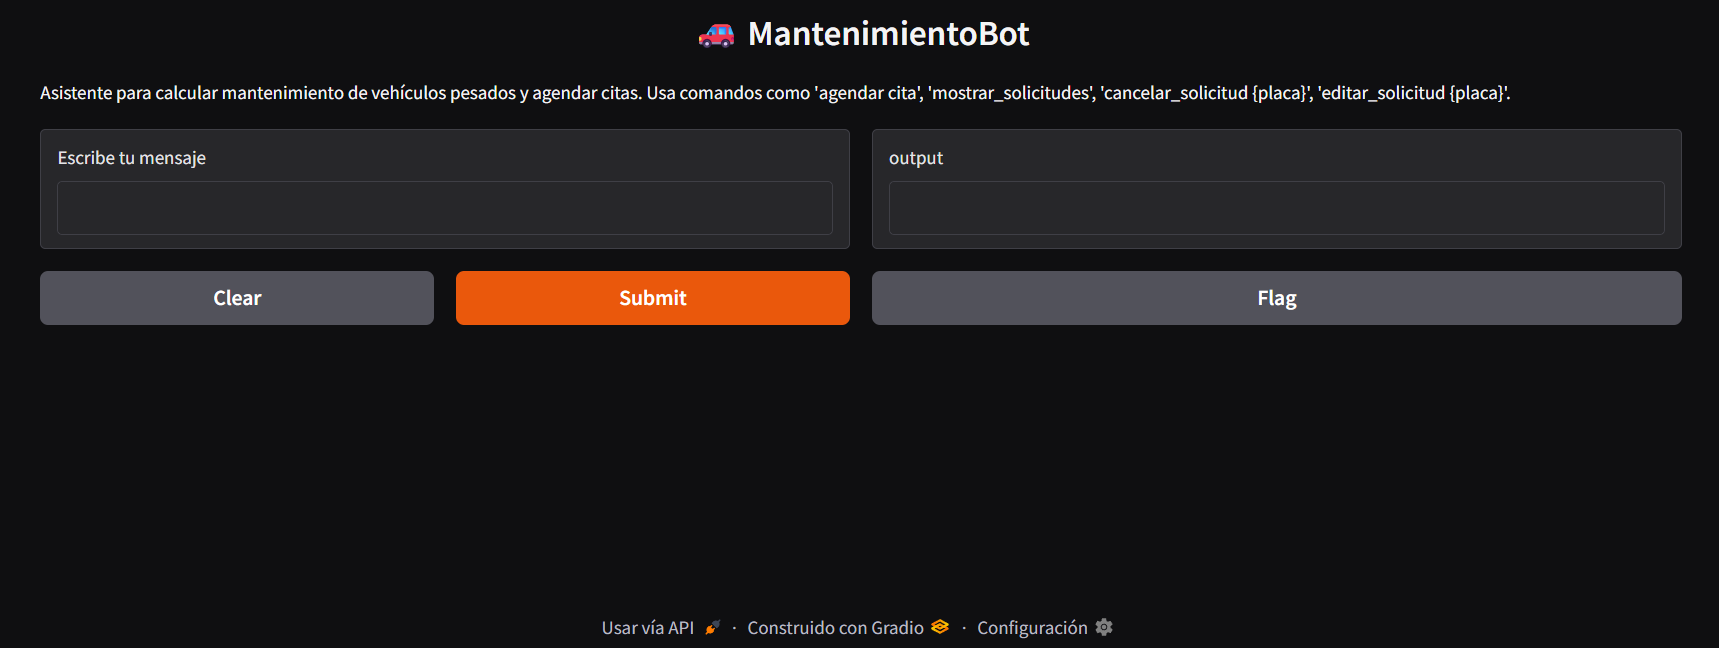